In [24]:
import pandas as pd
import numpy as np

import mplfinance as mpf

In [21]:
df=pd.read_csv(r"apple.csv")

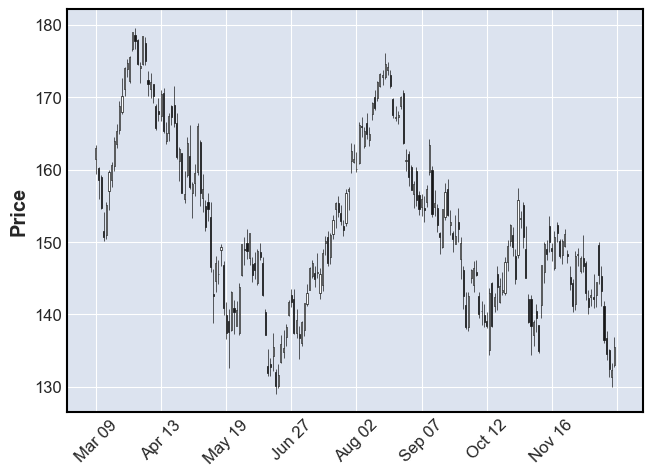

In [25]:
df.index=pd.to_datetime(df.Date)#索引转为日期
#df = df.iloc[::-1]#由于获取的数据是倒序的，需要将其调整为正序
mpf.plot(df[-200:],type='candle')#绘制最近200天的数据

In [26]:
df=df.drop(['Date','Adj Close','Volume'],axis=1)
df

,Open,High,Low,Close
Date,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348
1980-12-15,0.122210,0.122210,0.121652,0.121652
1980-12-16,0.113281,0.113281,0.112723,0.112723
1980-12-17,0.115513,0.116071,0.115513,0.115513
1980-12-18,0.118862,0.119420,0.118862,0.118862
...,...,...,...,...
2022-12-15,141.110001,141.800003,136.029999,136.500000
2022-12-16,136.690002,137.649994,133.729996,134.509995
2022-12-19,135.110001,135.199997,131.320007,132.369995


In [27]:
dataX=[]#属性
dataY=[]#标签
k=0
tempX=[]#储存某个历史590天数据
tempY=[]#储存某个未来6天数据
for index, rows in df.iterrows():
    if k<10590:
        k+=1
        tempX.append([rows['Open'],rows['Close'],rows['High'],rows['Low']])
        continue
    if k<10596:
        k+=1
        tempY.append([rows['Open'],rows['Close'],rows['High'],rows['Low']])
        continue
    dataX.append(tempX[:])
    dataY.append(tempY[:])
 
    tempX=tempX[1:]+tempY[:1]
 
    tempY=tempY[1:]
    tempY.append([rows['Open'],rows['Close'],rows['High'],rows['Low']])
dataX.append(tempX[:])#加上最后一项
dataY.append(tempY[:])#加上最后一项

In [28]:
### 使用了 LSTM模型 取apple数据中后596个数据进行训练 并训练后的模型对2023年1月5日后的5天进行预测

import torch
import torch.utils.data as Data
 
dataX=torch.tensor(dataX,dtype=torch.float)#列表转Tensor
dataY=torch.tensor(dataY,dtype=torch.float)#列表转Tensor
 
dataset=Data.TensorDataset(dataX,dataY)

train_size=int(0.8*len(dataset))
test_size=len(dataset)-train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])#以8:2比例划分训练集和测试集
 
train_loader = Data.DataLoader(
            dataset=train_dataset,
            batch_size=64,
            shuffle=False
        )
test_loader = Data.DataLoader(
            dataset=test_dataset,
            batch_size=64,
            shuffle=False
        )

In [29]:
from torch.nn import LSTM,Module,Linear
class MyModel(Module):
    def __init__(self):
        super(MyModel,self).__init__()
        self.lstm=LSTM(input_size=4,hidden_size=4,num_layers=2,batch_first=True)
        self.linear=Linear(42360,24)#将结果映射到7天的数据
    def forward(self,x):
        return self.linear(self.lstm(x)[0].reshape(-1,42360))

In [30]:
import torch.nn.functional as F
model=MyModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossList=[]#记录训练loss
lossListTest=[]#记录测试loss
for epoch in range(40):
    loss_nowEpoch=[]
    model.train()
    for step, (batch_x, batch_y) in enumerate(train_loader):
        out=model(batch_x)#模型输入
        Loss = F.mse_loss(out,batch_y.view(-1,24))#loss计算，将batch_y从(64,7,4)变形为(64,28)
        optimizer.zero_grad()#当前batch的梯度不会再用到，所以清除梯度
        Loss.backward()#反向传播计算梯度
        optimizer.step()#更新参数
        loss_nowEpoch.append(Loss.item())
        break
    lossList.append(sum(loss_nowEpoch)/len(loss_nowEpoch))
 
    loss_nowEpochTest = []
    model.eval()
    for step, (batch_x, batch_y) in enumerate(test_loader):
        out = model(batch_x)
        Loss = F.mse_loss(out, batch_y.view(-1, 24))  # 将batch_y从(64,7,4)变形为(64,28)
        loss_nowEpochTest.append(Loss.item())
        break
    lossListTest.append(sum(loss_nowEpochTest)/len(loss_nowEpochTest))
 
    print(">>> EPOCH{} averTrainLoss:{:.3f} averTestLoss:{:.3f}".format(epoch+1, lossList[-1],lossListTest[-1]))

>>> EPOCH1 averTrainLoss:19214.092 averTestLoss:16949.150
>>> EPOCH2 averTrainLoss:17523.908 averTestLoss:15337.590
>>> EPOCH3 averTrainLoss:15885.254 averTestLoss:13778.969
>>> EPOCH4 averTrainLoss:14299.030 averTestLoss:12277.895
>>> EPOCH5 averTrainLoss:12769.852 averTestLoss:10839.665
>>> EPOCH6 averTrainLoss:11303.023 averTestLoss:9469.880
>>> EPOCH7 averTrainLoss:9904.165 averTestLoss:8174.292
>>> EPOCH8 averTrainLoss:8579.060 averTestLoss:6958.684
>>> EPOCH9 averTrainLoss:7333.524 averTestLoss:5828.744
>>> EPOCH10 averTrainLoss:6173.290 averTestLoss:4789.922
>>> EPOCH11 averTrainLoss:5103.864 averTestLoss:3847.263
>>> EPOCH12 averTrainLoss:4130.364 averTestLoss:3005.213
>>> EPOCH13 averTrainLoss:3257.317 averTestLoss:2267.378
>>> EPOCH14 averTrainLoss:2488.433 averTestLoss:1636.261
>>> EPOCH15 averTrainLoss:1826.335 averTestLoss:1112.951
>>> EPOCH16 averTrainLoss:1272.259 averTestLoss:696.802
>>> EPOCH17 averTrainLoss:825.727 averTestLoss:385.083
>>> EPOCH18 averTrainLoss:484.20

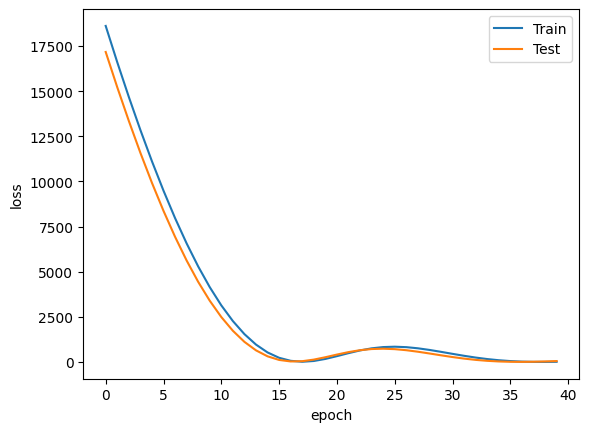

In [12]:
 import matplotlib.pyplot as plt
plt.plot(list(range(40)),lossList,label='Train')
plt.plot(list(range(40)),lossListTest,label='Test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [15]:
import torch

In [13]:
# 使用了 LSTM模型 取apple数据中后596个数据进行训练 并训练后的模型对2023年1月5日后的5天进行预测
from torch import nn
time_step = 20
input_size = 4
learning_rate = 0.001
hidden_size = 64
num_layers = 1
end_lenth=6500
class Bi_LSTM(nn.Module):
    """搭建LSTM"""
    def __init__(self):
        super(Bi_LSTM, self).__init__()
        # LSTM层
        self.lstm = nn.LSTM(input_size=input_size,      # 输入单元个数
                            hidden_size=hidden_size,    # 隐藏单元个数
                            num_layers=num_layers,      # 隐藏层数
                            batch_first=True,           # True：[batch, time_step, input_size] False:[time_step, batch, input_size]
                            bidirectional=True)

        # 输出层
        self.output_layers = nn.Linear(in_features=hidden_size*2,    # 输入特征个数
                                       out_features=1)  # 输出特征个数

    def forward(self, x):
        lstm_out, (h_n, h_c) = self.lstm(x, None)   #
        # print(lstm_out.shape)
        output = self.output_layers(lstm_out[:, -1, :])    # 选择最后一个时刻的LSTM作为输出
        return output


In [14]:
import torch.nn.functional as F
model=Bi_LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossList=[]#记录训练loss
lossListTest=[]#记录测试loss
for epoch in range(40):
    loss_nowEpoch=[]
    model.train()
    for step, (batch_x, batch_y) in enumerate(train_loader):
        out=model(batch_x)#模型输入
        Loss = F.mse_loss(out,batch_y.view(-1,24))#loss计算，将batch_y从(64,7,4)变形为(64,28)
        optimizer.zero_grad()#当前batch的梯度不会再用到，所以清除梯度
        Loss.backward()#反向传播计算梯度
        optimizer.step()#更新参数
        loss_nowEpoch.append(Loss.item())
        break
    lossList.append(sum(loss_nowEpoch)/len(loss_nowEpoch))
 
    loss_nowEpochTest = []
    model.eval()
    for step, (batch_x, batch_y) in enumerate(test_loader):
        out = model(batch_x)
        Loss = F.mse_loss(out, batch_y.view(-1, 24))  # 将batch_y从(64,7,4)变形为(64,28)
        loss_nowEpochTest.append(Loss.item())
        break
    lossListTest.append(sum(loss_nowEpochTest)/len(loss_nowEpochTest))
 
    print(">>> EPOCH{} averTrainLoss:{:.3f} averTestLoss:{:.3f}".format(epoch+1, lossList[-1],lossListTest[-1]))

C:\Users\can\AppData\Local\Temp\ipykernel_12668\363502565.py:11: UserWarning: Using a target size (torch.Size([1, 24])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  Loss = F.mse_loss(out,batch_y.view(-1,24))#loss计算，将batch_y从(64,7,4)变形为(64,28)
C:\Users\can\AppData\Local\Temp\ipykernel_12668\363502565.py:23: UserWarning: Using a target size (torch.Size([1, 24])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  Loss = F.mse_loss(out, batch_y.view(-1, 24))  # 将batch_y从(64,7,4)变形为(64,28)


>>> EPOCH1 averTrainLoss:18706.904 averTestLoss:19257.971
>>> EPOCH2 averTrainLoss:18657.766 averTestLoss:19213.672
>>> EPOCH3 averTrainLoss:18614.838 averTestLoss:19176.094
>>> EPOCH4 averTrainLoss:18577.680 averTestLoss:19141.949
>>> EPOCH5 averTrainLoss:18543.348 averTestLoss:19134.352
>>> EPOCH6 averTrainLoss:18535.662 averTestLoss:19104.434
>>> EPOCH7 averTrainLoss:18505.979 averTestLoss:19075.900
>>> EPOCH8 averTrainLoss:18478.686 averTestLoss:19049.494
>>> EPOCH9 averTrainLoss:18453.250 averTestLoss:19026.287
>>> EPOCH10 averTrainLoss:18430.379 averTestLoss:19006.484
>>> EPOCH11 averTrainLoss:18410.650 averTestLoss:18987.990
>>> EPOCH12 averTrainLoss:18392.238 averTestLoss:18969.367
>>> EPOCH13 averTrainLoss:18373.725 averTestLoss:18949.766
>>> EPOCH14 averTrainLoss:18354.174 averTestLoss:18928.430
>>> EPOCH15 averTrainLoss:18332.725 averTestLoss:18904.133
>>> EPOCH16 averTrainLoss:18308.213 averTestLoss:18875.852
>>> EPOCH17 averTrainLoss:18279.830 averTestLoss:18850.906
>>> EP

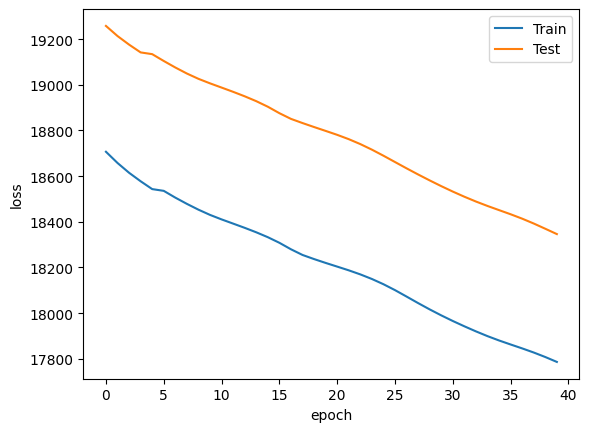

In [15]:
 
import matplotlib.pyplot as plt
plt.plot(list(range(40)),lossList,label='Train')
plt.plot(list(range(40)),lossListTest,label='Test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [16]:
# 使用了 GRUNet模型 取apple数据中后596个数据进行训练 并训练后的模型对2023年1月5日后的5天进行预测
time_step = 20
input_size = 4
learning_rate = 0.001
end_lenth=6500
class GRUNet(nn.Module):
 
    def __init__(self, input_size=4):
        super(GRUNet, self).__init__()
        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.out = nn.Sequential(
            nn.Linear(128, 1)
        )
 
    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)  # None 表示 hidden state 会用全0的 state
        out = self.out(r_out[:, -1])
        print(out.shape)
        return out


In [17]:

import torch.nn.functional as F
model=GRUNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossList=[]#记录训练loss
lossListTest=[]#记录测试loss
for epoch in range(40):
    loss_nowEpoch=[]
    model.train()
    for step, (batch_x, batch_y) in enumerate(train_loader):
        out=model(batch_x)#模型输入
        Loss = F.mse_loss(out,batch_y.view(-1,24))#loss计算，将batch_y从(64,7,4)变形为(64,28)
        optimizer.zero_grad()#当前batch的梯度不会再用到，所以清除梯度
        Loss.backward()#反向传播计算梯度
        optimizer.step()#更新参数
        loss_nowEpoch.append(Loss.item())
        break
    lossList.append(sum(loss_nowEpoch)/len(loss_nowEpoch))
 
    loss_nowEpochTest = []
    model.eval()
    for step, (batch_x, batch_y) in enumerate(test_loader):
        out = model(batch_x)
        Loss = F.mse_loss(out, batch_y.view(-1, 24))  # 将batch_y从(64,7,4)变形为(64,28)
        loss_nowEpochTest.append(Loss.item())
        break
    lossListTest.append(sum(loss_nowEpochTest)/len(loss_nowEpochTest))
 
    print(">>> EPOCH{} averTrainLoss:{:.3f} averTestLoss:{:.3f}".format(epoch+1, lossList[-1],lossListTest[-1]))

torch.Size([1, 1])


C:\Users\can\AppData\Local\Temp\ipykernel_12668\1307378264.py:11: UserWarning: Using a target size (torch.Size([1, 24])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  Loss = F.mse_loss(out,batch_y.view(-1,24))#loss计算，将batch_y从(64,7,4)变形为(64,28)


torch.Size([1, 1])
>>> EPOCH1 averTrainLoss:18979.799 averTestLoss:19513.678


C:\Users\can\AppData\Local\Temp\ipykernel_12668\1307378264.py:23: UserWarning: Using a target size (torch.Size([1, 24])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  Loss = F.mse_loss(out, batch_y.view(-1, 24))  # 将batch_y从(64,7,4)变形为(64,28)


torch.Size([1, 1])
torch.Size([1, 1])
>>> EPOCH2 averTrainLoss:18887.961 averTestLoss:19423.322
torch.Size([1, 1])
torch.Size([1, 1])
>>> EPOCH3 averTrainLoss:18803.139 averTestLoss:19341.176
torch.Size([1, 1])
torch.Size([1, 1])
>>> EPOCH4 averTrainLoss:18727.480 averTestLoss:19268.139
torch.Size([1, 1])
torch.Size([1, 1])
>>> EPOCH5 averTrainLoss:18658.525 averTestLoss:19201.955
torch.Size([1, 1])
torch.Size([1, 1])
>>> EPOCH6 averTrainLoss:18595.553 averTestLoss:19142.318
torch.Size([1, 1])
torch.Size([1, 1])
>>> EPOCH7 averTrainLoss:18538.883 averTestLoss:19087.877
torch.Size([1, 1])
torch.Size([1, 1])
>>> EPOCH8 averTrainLoss:18486.809 averTestLoss:19036.357
torch.Size([1, 1])
torch.Size([1, 1])
>>> EPOCH9 averTrainLoss:18437.289 averTestLoss:18986.033
torch.Size([1, 1])
torch.Size([1, 1])
>>> EPOCH10 averTrainLoss:18388.811 averTestLoss:18935.873
torch.Size([1, 1])
torch.Size([1, 1])
>>> EPOCH11 averTrainLoss:18340.396 averTestLoss:18885.547
torch.Size([1, 1])
torch.Size([1, 1])


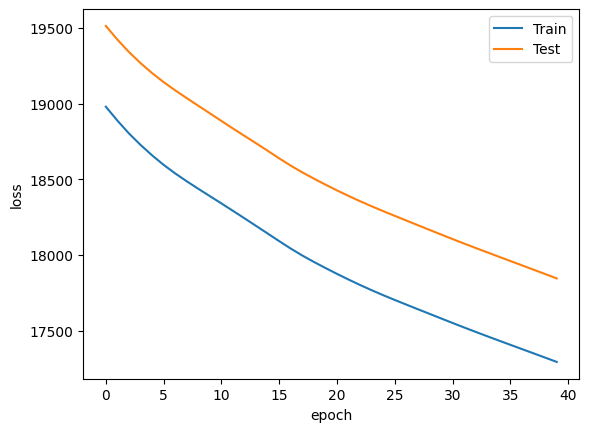

In [18]:
 
import matplotlib.pyplot as plt
plt.plot(list(range(40)),lossList,label='Train')
plt.plot(list(range(40)),lossListTest,label='Test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 最终选择LSTM模型

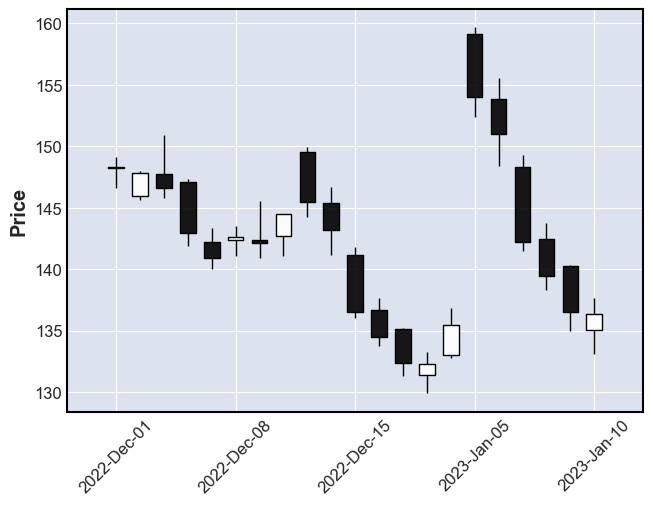

In [34]:
X=torch.tensor(df[['Open','Close','High','Low']][-10590:].to_numpy())
Y=model(X.view(1,10590,4).float()).reshape(6,4)
result=pd.DataFrame(torch.vstack((X,Y)).detach().numpy())
result.index=list(df.index[-10590:])+[pd.Timestamp('2023-01-5 00:00:00'),pd.Timestamp('2023-01-6 00:00:00'),
                              pd.Timestamp('2023-01-7 00:00:00'),pd.Timestamp('2023-01-8 00:00:00'),
                              pd.Timestamp('2023-01-9 00:00:00'),pd.Timestamp('2023-01-10 00:00:00')]
result.columns=['Open','Close','High','Low']
mpf.plot(result[-21:],type='candle')


In [35]:
result[-6:]

,Open,Close,High,Low
2023-01-05,159.133194,153.994553,159.664352,152.398804
2023-01-06,153.813644,151.023468,155.513916,148.377960
2023-01-07,148.277771,142.191528,149.274216,141.461685
2023-01-08,142.434631,139.410660,143.747513,138.331757
2023-01-09,140.216309,136.500854,140.332825,134.940399
2023-01-10,135.057343,136.352020,137.650497,133.088715


In [38]:
result[-6:].to_excel(excel_writer= r"mession.xlsx")